<a href="https://colab.research.google.com/github/Seba485/Deep-Learning-project/blob/DEV_Hyun/alzheimer_mri_model_tensorflow_2_3_data_loading.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Methods: project work 2023

Every new markdown cell has  'NEW:'      written before

Original markdown cells not useful are commented out "( <!-- [.]-->)"

Put your dataset path  containing the dataset, after " dataset_path " variable.

Old code not useful is commented (#)

Be aware of all packages needed to be installed to import functions and libraries of the first cell
# Introduction + Set-up

<!--Machine learning has a phenomenal range of application in the health sciences. This tutorial will go over the complete pipeline to build a model that can determine the dementia level of an Alzheimer's patient from their MRI image. This model achieves an a high ROC AUC score.

This tutorial highlights the ease of building a CNN using `tf.keras`. Additionally, TensorFlow 2.3 has new features, including easy data loading utilities that were previously not available in TensorFlow 2.2. We'll be seeing how easy data loading is with these additional features.-->

We'll be using a GPU accelerator for this NB.

# ABSTRACT AND LITERATURE REVIEW
NEW: 

# NEW DATA: Alzheimer MRI Preprocessed Dataset (128 x 128)

The Data is collected from several websites/hospitals/public repositories. The Dataset is consists of Preprocessed MRI (Magnetic Resonance Imaging) Images. All the images are resized into 128 x 128 pixels. The Dataset has four classes of images. The Dataset is consists of total 6400 MRI images. Class - 1: Mild Demented (896 images) Class - 2: Moderate Demented (64 images) Class - 3: Non Demented (3200 images) Class - 4: Very Mild Demented (2240 images) Motive The main motive behind sharing this dataset is to design/develop an accurate framework or architecture for the classification of Alzheimers Disease

We'll try to make our code as adaptable as possible to analogue datasets. For example, we will define batch size according to the number of files, or we will implement pixels resizing  inside the model.


NEW:
The original code imported all necessary packages for previous version
We imported additional packages and removed redundant or unused packages.

In [7]:
##### import packages #####
import os
from PIL import Image
from glob import glob
import shutil
import itertools
import numpy as np
import pandas as pd
import tensorflow as tf
print(tf.__version__)

# import kaggledatasets
import matplotlib.pyplot as plt
import random
from sklearn.model_selection import train_test_split
from sklearn.model_selection import ParameterGrid
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import confusion_matrix, classification_report
try:
  from scikeras.wrappers import KerasClassifier
except:
  #pip install scikeras
  from scikeras.wrappers import KerasClassifier
from keras.models import load_model
import itertools



2.14.0


NEW: 
The original code sets up a TensorFlow TPU (Tensor Processing Unit) environment and prints the number of replicas in sync. The   \strategy.num_replicas_in_sync attribute, namely number of replicas in sync, is the number of devices (TPU cores) that are used in parallel during training.
STRENGTH:  When using TPU, the training process can be distributed across multiple TPU cores for increasing computational power.

In addition, we added the code to check if the code is running the code on Google Colab environment or on local environment.
Apart from TPU, we considered running the code on GPU environment. Therfore, code for checking the availablity of GPU usage and the number of GPUs available was included.


In [8]:

##### set-up gpu/tpu #####
# check & mount in case of using colab
'''
try:
    from google.colab import drive
    drive.mount('/content/drive/')
    print('running the notebook in colab')
except:
    pass
'''

# check if tpu is available
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    print('Device:', tpu.master())
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
except:
    print('No TPU found')
    strategy = tf.distribute.get_strategy()
print('Number of replicas:', strategy.num_replicas_in_sync)

# check if gpu is available
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    print(f"Found {len(gpus)} GPU")
    try:
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)

No TPU found
Number of replicas: 1


It's always a good idea to set constant variables instead of hard coding numbers into your code. It saves time later when you want to change certain parameters.

NEW:
The orifinal code defines  parameters for the transformation within the pipeline input data mechanism : with AUTOTUNE, tf.data API will automatically tune the performance of data loading operation, namely will adapt the level of parallelism in executing operations based on available computational resources; this can be particularly useful when working with distributed computing environments like TPUs or GPUs, where the performance characteristics may vary.  This helps to make the  input pipeline more flexible, faster, highly performant and adaptive to different hardware configurations. 

The original code also defines variables for epochs, image size and batch size.

STRENGTH: performance improvement of input data pipeline Tensorflow
WEAKNESS: Batch size fixed and not be on dataset numbers

We set image size for our new dataset, set epoch size later for convenience.

We calculate Batch SIze later on the code and define number of epochs later, before fitting the model

In [9]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
#BATCH_SIZE = 16 * strategy.num_replicas_in_sync 
IMAGE_SIZE = [128, 128]  #[176,208]
# EPOCHS = 15  

# Data Loading

<!--We'll be using a [Kaggle Alzheimer's dataset](https://www.kaggle.com/tourist55/alzheimers-dataset-4-class-of-images) for our tutorial. -->

NEW: We changed dataset: we took another preprocessed data because test and training contained different sections  of same subjects
some volumes and some single slices ?

We also saw that many comments in kaggle said it was a not reliable dataset

The new dataset is as well a Kaggle dataset, had the same categories and has more citations related, so should be more reliable
Dataset was not splitted in train and test set as the previous dataset. 

`tf.keras` has a new preprocessing function that can easily load in images for a directory. In order for this function to work, the data has to be structured in a file directory format.

```
main_directory/
    class1/
        class1_images
    class2/
        class2_images
```

If you input the `main_directory` into the `tf.keras` function, it will figure out the rest!

<!--In our case, the `train` directory is our main directory.

We are also specifying a 80:20 split for our training and validation datasets. To learn more about the importance of having a validation split, check out this [lesson](https://developers.google.com/machine-learning/crash-course/validation/another-partition) from Google's Machine Learning Crash Course.-->




NEW: The  new dataset does not have ready folders corresponding to train / test with internal folders division, as the old had. In order to keep  `tf.keras` preprocessing function as function for input data ( this takes you from one images directory on a disk to a n tf.data.Dataset in just two codes lines), we create train and test folders respecting the proportion among classes: folders are created (and files are moved) only if not present (and if files not already moved): the code, if run multiple times, does this only once.


We load images from the disk and use 80% for training and 20% for validation. We chose batch size customised to our dataset (proportional to number of files in folders, to make the code more adaptable)

We set dataset splitting ratio as train:val:test=0.8*0.8:0.8*0.2:0.2.


In [4]:
##### split and save dataset into train/val and test data #####

# specify local dataset path

# WRITE YOUR OWN PATH CONTAINING DATASET 
dataset_path = "/Dataset"

train_path = dataset_path+'/train' #folder doesn’t exist yet
test_path= dataset_path+'/test'
test_size = 0.2
val_size = 0.2
classes = os.listdir(dataset_path)
if 'test' in classes:
   classes.remove('test')
if 'train' in classes:
  classes.remove('train')
print(classes)  # if train / test folders not created (first time running code), 'test' and  'train' not present


if os.path.isdir(train_path):
    print('Dataset has already been splited and saved into train/val and test data.')
else:
    os.makedirs(train_path, exist_ok=True)
    os.makedirs(test_path, exist_ok=True)
    print(classes)

    for class_name in classes:
        print(class_name)
        class_path = os.path.join(dataset_path, class_name)
        train_class_path = os.path.join(train_path, class_name)
        test_class_path = os.path.join(test_path, class_name)

        # Get the list of files in the class
        files = os.listdir(class_path)
        os.makedirs(train_class_path, exist_ok=True)
        os.makedirs(test_class_path, exist_ok=True)

        # Divide the class dataset into training and test sets
        train_files, test_files = train_test_split(files, test_size=test_size, random_state=42)

        # Save the training files to the training folder
        for file in train_files:
            src_path = os.path.join(class_path, file)
            dst_path = os.path.join(train_path, class_name, file)
            shutil.copy(src_path, dst_path)

        # Save the test files to the test folder
        for file in test_files:
            src_path = os.path.join(class_path, file)
            dst_path = os.path.join(test_path, class_name, file)
            shutil.copy(src_path, dst_path)


##### split train/val into train and val data #####
# set batch size: 1) batch_size=40, 2) take 10% of the train+val set as the batch size
customized_batchsize = True # True if we want customized batch size over the dataset size
if customized_batchsize:
    trainval_cnt = sum([len(files) for _, _, files in os.walk(train_path)])
    test_cnt = sum([len(files) for _, _, files in os.walk(test_path)]) # might use this in case of using different batch size for test set
    BATCH_SIZE = round(trainval_cnt * val_size * 0.1)
else:
    BATCH_SIZE = 40
print("Batch Size for train, validation and test set:", BATCH_SIZE)

# split dataset and save into tf Dataset object
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    train_path,
    validation_split=val_size,
    subset="training",
    seed=1337,
    image_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
)
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    train_path,
    validation_split=val_size,
    subset="validation",
    seed=1337,
    image_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
)

['MildDemented', 'ModerateDemented', 'NonDemented', 'VeryMildDemented']
Dataset has already been splited and saved into train/val and test data.
Batch Size for train, validation and test set: 102


Found 5118 files belonging to 4 classes.
Using 4095 files for training.
Found 5118 files belonging to 4 classes.
Using 1023 files for validation.


We'll be renaming the class names and specifying the number of classes. In this case, we have 4 classes of dementia.

NEW: The original code renames class names for training and validation set and sets the variable for number of classes.
We didn't raname classes as we thought this might create some problems with folders: classes names are left to be folders (previously created) names. We comment those lines.

In [5]:
#class_names = ['MildDementia', 'ModerateDementia', 'NonDementia', 'VeryMildDementia']
#train_ds.class_names = class_names
# val_ds.class_names = class_names
NUM_CLASSES = len(classes)

# Visualize the data

Now that our data has been easily loaded in, the next step is to visualize our images. This helps us understand what is being used as an input for our model. It also serves as a check to see if our images have been loaded in correctly.

NEW:  

The original code explores data at the very beginning before doing anything with them:  visualizes a grid of nine images along with their corresponding labels. astype("uint8") converts the pixel values to 8-bit unsigned integers, which is the format expected by Matplotlib for image display.
STRENGTH: look at some images to check they were uploaded in the right way and to have a preliminary look at data. 
WEAKNESSES: just plot some images from the first batch, does not distinguish graphically classes. Does not look for unbalanced classes in the training set by doing some exploratory plot (for example histograms).

We display of samples for each class by counting number of files for each folder, to check proportion of test and training classes. To do this, build a dictionary where keys are folder names (-> the 4 classes) and values are the filenames for the files in each folder (for both test and train). We then show  images divided by classes (columns) to see if differences are visible by hand.


MildDemented class has 716 samples in train set.
ModerateDemented class has 51 samples in train set.
NonDemented class has 2560 samples in train set.
VeryMildDemented class has 1791 samples in train set.
MildDemented class has 180 samples in test set.
ModerateDemented class has 13 samples in test set.
NonDemented class has 640 samples in test set.
VeryMildDemented class has 449 samples in test set.


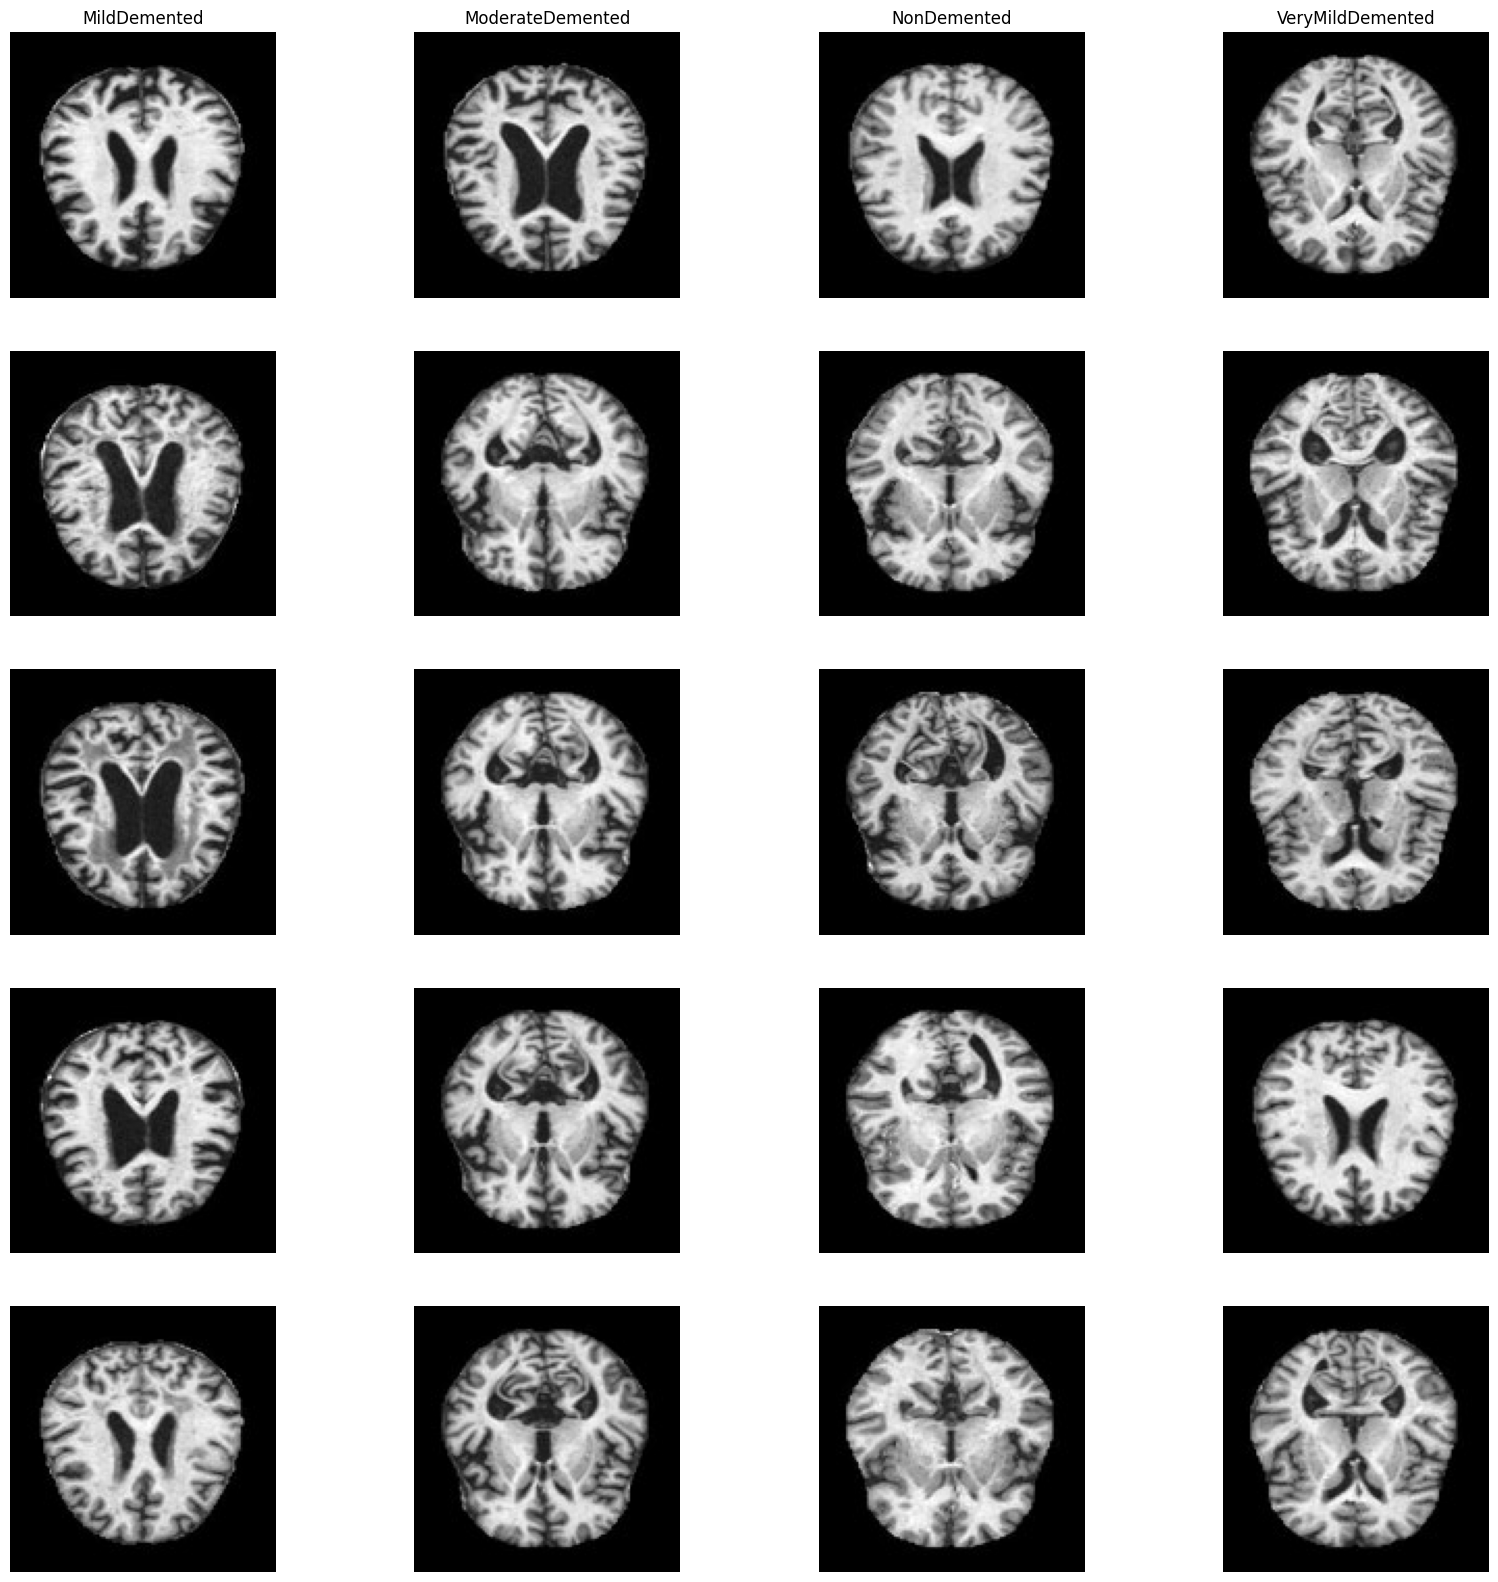

In [6]:
##### check the number of samples within each class in train set #####
# create a dictionary where:

# - keys are folder names (-> the 4 classes)
# - values are the filenames for the files in each folder : training set
imgs = {c: glob(os.path.join(train_path, c, "*")) for c in classes}
for key in imgs.keys():
   print("{} class has {} samples in train set.".format(key,len(imgs[key])))

# - keys are folder names (-> the 4 classes)
# - values are the filenames for the files in each folder :  test set
imgs = {c: glob(os.path.join(test_path, c, "*")) for c in classes}
for key in imgs.keys():
   print("{} class has {} samples in test set.".format(key,len(imgs[key])))



##### plot 5 samples per class #####
# CHANGE--> PLOT SOME (5) IMAGES PER CLASS ! TO SEE BETTER DIFFERENCES
nrows = 5
fig, axs = plt.subplots(nrows=nrows, ncols=len(classes), figsize=(20, 20))

for i, (c, fnames) in enumerate(imgs.items()): # i is the count, (images,labels) key and value
    axs[0,i].set_title(c)
    for n in range(nrows):
        fname = (fnames[n]).replace('\\','/')
        im = Image.open(fname)
        # im = im.convert('L') # image is already saved in 'L' mode
        axs[n,i].imshow(im, cmap='gray')
for ax in axs.flatten():
    ax.axis("off")

# NEW: A BETTER LOOK AT DATA !
We have a deeper esploratory data analysis .. TO DO !


In [6]:
tensors_train=observations_fromPrefetch(train_ds)  #list of 41 4D tensorflows tensors (102,128,128,3): 

list_of_arrays = [tensor.numpy() for tensor in tensors_train]  #list of 41 4D arrays  (102,128,128,3)
s=list_of_arrays[0].shape  # (102,128,128,3)

images_tot = [np.reshape((tensor), (-1, 128, 128, 3)) for tensor in list_of_arrays]  # 4D array (4095,128,128,3) 
images_tot = list(np.concatenate(images_tot, axis=0))  # list of 4095 3d arrays

example=images_tot[0]   #3darray (128,128,3); all values in 3rd dimension are the same --> example[i,j,1]=example[i,j,2]=example[i,j,3]

sb0=np.count_nonzero(example[:,:,1]!=example[:,:,2]) #0
sb02=np.count_nonzero(example[:,:,1]!=example[:,:,0]) #0 
# it's a tensor with three same channels

maxvalue=np.max(example)
minvalue=np.min(example)
medvalue=np.mean(example)

NameError: name 'observations_fromPrefetch' is not defined

NEW: We define a function to extract our observations and labels from Prefetch dataset. We chose to keep this format for the Dataset as it is required as model input

In [7]:
##### extract numpy arrays of images and labels from tensorflow Dataset Object #####
train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

def images_labels_fromPrefetch(dataset):
    dataset_it = dataset.as_numpy_iterator() # Numpy iterator
    all_labels=[]; all_images=[]
    for batch_images, batch_labels in dataset_it:
        all_labels.extend(batch_labels)
        all_images.append(batch_images)
    return all_images, all_labels

tensors_train, labels_train = images_labels_fromPrefetch(train_ds)
_, labels_val = images_labels_fromPrefetch(val_ds)

NEW: We check for classes unbalances and plot an histogram of classes distribution. Two subplots: percentage of samples per class and number of samples per class

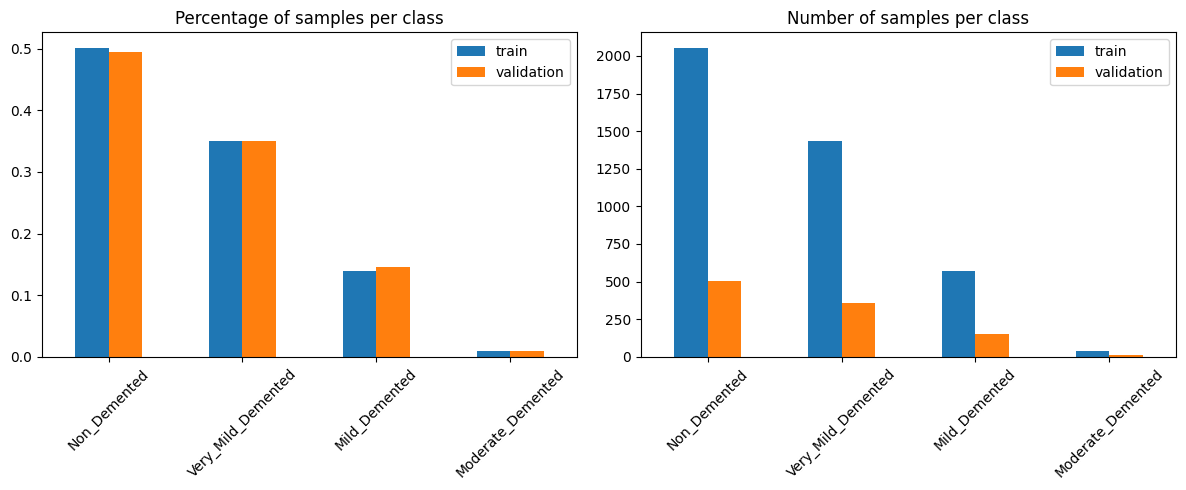

<Figure size 640x480 with 0 Axes>

In [8]:
##### check class ditribution of dataset #####
train_labels = [classes[idx] for idx in labels_train]
val_labels = [classes[idx] for idx in labels_val]

fig,axs = plt.subplots(1,2,figsize=(12,5))

vis_ratio = True # if we want to plot the num of samples or the ratio of each class
vis_title = 'Percentage of samples per class' if vis_ratio else 'Number of samples per class'
df_cnt = pd.concat([pd.Series(train_labels).value_counts(normalize=vis_ratio), pd.Series(val_labels).value_counts(normalize=vis_ratio)], axis=1)
df_cnt.plot(kind='bar', ax=axs[0], title=vis_title, rot=45)
axs[0].legend(['train', 'validation'])

plt.subplot(1,2,2)
vis_ratio = False # if we want to plot the num of samples or the ratio of each class
vis_title = 'Percentage of samples per class' if vis_ratio else 'Number of samples per class'
df_cnt = pd.concat([pd.Series(train_labels).value_counts(normalize=vis_ratio), pd.Series(val_labels).value_counts(normalize=vis_ratio)], axis=1)
df_cnt.plot(kind='bar', ax=axs[1], title=vis_title, rot=45)
axs[1].legend(['train', 'validation'])

plt.tight_layout()

# Show the plot
plt.show()
plt.savefig('Dataset distribution.png')


NEW: IT IS possible to see how the dataset is unbalanced (few samples for moderate-dementia), is usefull to apply data aumentation in a specific manner for each class in order to prevent understimation of the minority class nad misleading performances.

In fact, in neuroimaging, a large number of scans related to AD patient’s availability are a major issue since  deep learning models  provide more effective results on more data [CITAZIONE]. In medical research, due to privacy concerns, the access to large data is a big problem [47], especially, the classification of cancer and AD are problematic due to lack of availability of data. The small imbalanced dataset creates overfitting problems during training of the model which affects the model efficiency. To overcome this issue, we need more data to enhance the effective accuracy in our proposed model. We used the augmentation technique.

# Deciding a Metric

The most conventional metric to use is probably accuracy. Accuracy, however, cannot be used for imbalanced datasets. Let's check how many images are in each class for our training data.
Our dataset is not balanced, so we cannot use accuracy as our metric. For this tutorial, we will be using ROC AUC. Intuitively, ROC AUC gives a score, with higher scores closer to 1 indicating that the different classes can be distinguishable for the model. A lower score closer indicates that the the model cannot distinguish between different classes. A score of 0.5 indicates that the ordering the images is pretty much random. Learn more about ROC AUC [here](https://developers.google.com/machine-learning/crash-course/classification/roc-and-auc).

NEW: we display number of classes for each class before data augmentation, to show the user the comparison before / after data augmentation

In [ ]:
#### display number of classes for each class before data augmentation #####
NUM_IMAGES_PRE = []

for label in class_names:
    dir_name = r"C:/Users/Utente/Documents/UNIVERSITA_ANNO_5/DEEP_LEARNING/GROUP_PROJECT/Deep-Learning-project/.vscode/Deep-Learning-project-1/archive/Dataset/train/"+label
    num=len([name for name in os.listdir(dir_name)])
    NUM_IMAGES_PRE.append(num)
    print("{} class has {} samples in training set".format(label,num))

# Feature Engineering

Because we are working with categorical and noncontinuous data, we want to convert our model into one-hot encodings. One-hot encodings are a way for the model to understand that we're looking at categorial instead of continuous data. Transforming features so that they'll be more understandable is called feature engineering. Learn more about feature engineering [here](https://developers.google.com/machine-learning/crash-course/representation/feature-engineering).

NEW The function changes data representation in an "easier" way: converts the label into a one-hot encoded tensor (one-hot representation with a depth of NUM_CLASSES) using TensorFlow's tf.one_hot function, and returns the original image along with its one-hot encoded label. Many deep learning models can operate only on numeric variables for the algorIthm efficiency [citation 2]. For categorical variables for which no ordinal relationship exists, as these, the integer encoding is not enough. One hot encoding converts categorical data to numbers before fitting the model: a new binary variable (column) is added to the dataset for each unique categorical value in the variable (the presence or absence of a "1" in a column indicates the class of the input sample) and the original categorical variable is removed from the dataset ; this avoids introducing ordinal relationships between labels because they are treated as distinct and unrelated; here this works well since target only has 4 possible values [SLIDE PROF ?]. One more reason to apply this function is that many loss functions, such as categorical cross-entropy [citation 3] expect the target labels to be in one-hot encoded format.

In [9]:
# Function for one hot encoding of our data
def one_hot_label(image, label):
    label = tf.one_hot(label, NUM_CLASSES)
    return image, label

train_ds = train_ds.map(one_hot_label, num_parallel_calls=AUTOTUNE)
val_ds = val_ds.map(one_hot_label, num_parallel_calls=AUTOTUNE)

The following cell makes calling images from our dataset more efficient.

In [10]:
train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

# NEW: Class specific data augmentation



NEW: We define layers for data augmentations. For these, we have chosen those tranformations that we found in literature [] , but we have built only those layers that do not modify image size. For example in [], a research work that was reference for us, they used width shift range, height shift range, shear range were applied but for us the model didn't work as image size was altered: we could have filled this with zero-padding or other filling techniques but having not any expertize and risking of making a dataset too "artificial", we decided to apply only the following transformations: random zoom in (height factor and width factot negative, see Keras documentation https://www.tensorflow.org/api_docs/python/tf/keras/layers/), random rotation, random flip, random  translation, random brightness.
Data augmentation is really adapted for our specific dataset: we could not do this inside the model, even if this would have made our model more transferable.

Empty spaces are filled according to fill_mode: we first put fill_mode = "reflect", but looking carefully at augmented data we realised that  augmented images they were not suitable for representing original images (looked like aliasing artifact). SO we changed fill mode= "constant" and it worked better, saving us from processing the image with operators and thresholds.  Parametre interpolation was chosen to be "bilinear" good for general-purpose smoothing but slightly blurring the image [ CIT]

We set always the same seed for code repetability: this was really important here since it's about input dataset that will fit parameters.



In [11]:
## Layers for data augmentation

# randomly zoom in or out on each axis 
RandomZoom_layer1=(tf.keras.layers.RandomZoom(
    height_factor=(-0.1, -0.3),  # lower and upper bound for zooming vertically
    width_factor=(-0.1, -0.3), #lower and upper bound for zooming horizontally
    fill_mode="constant",
    seed=2023
))

# apply random rotation
RandomRotation_layer1=tf.keras.layers.RandomRotation(
    (-0.2,0.2),  #lower and upper bound for rotating clockwise and counter-clockwise. (+ counter clock-wise, - clock-wise)
    fill_mode='constant',
    interpolation='bilinear',
    seed=2023)

# randomly flips images 
RandomFlip_layer1=tf.keras.layers.RandomFlip(
    mode="horizontal_and_vertical", seed=2023)

# randomly translates images
RandomTranslation_layer1=tf.keras.layers.RandomTranslation(
    (-0.2,0.2), #height factor: lower and upper bound for shifting vertically
     (-0.2,0.2), #width factor: ower and upper bound for shifting horizontally
    fill_mode='constant',
    interpolation='bilinear',
    seed=2023)

# randomly adjusts brightness
RandomBrightness_layer1=tf.keras.layers.RandomBrightness(
    (-0.2,0.2), seed=2023)  #lower bound and upper bound of the brightness adjustment (+ reduced brightness, - increases brightness)

NEW: The following cell is a function that saves the image, or the augmented image, that it receives as first input and puts it inside the folder assigned to "folderto".
Morever a function is defined that rescales nd arrays images. During data augmentation (following cell), each image before and after being augmented is rescaled [W]HY RESIZING ?]


In [ ]:
def save_augmented_image(image,i,label,folderto,transf=""):
  image_array = tf.keras.preprocessing.image.img_to_array(image)
  filename = f"image_{i}_label_{label}_{transf}.jpg"  # Use a counter or other identifiers        # Create a unique filename or use some identifier based on your datase
  image_path = os.path.join(folderto, filename).replace("\\","/")  # Specify the complete path for saving the image
  tf.keras.preprocessing.image.save_img(image_path, image_array)          # Save the image using a suitable library like PIL or OpenCV

def rescale_im(im):
  min_value = np.min(im)
  max_value = np.max(im)
  scaled_im = (im - min_value) / (max_value - min_value)
  return scaled_im

In [15]:
# DATA AUGMENTATION FOR BALANCING CLASSES

#Class - 1: Mild Demented (896 images)
#Class - 2: Moderate Demented (64 images)
#Class - 3: Non Demented (3200 images)
#Class - 4: Very Mild Demented (2240 images) 


#EXTRACT LABELS
import random
labels_train=labels_fromPrefetch(train_ds)   #1d array of dimension (4095)       
number_of0=np.count_nonzero(labels_train==0)  #568= Class 1 : Mild Demented--> 3,6 (=4) data aug
number_of1=np.count_nonzero(labels_train==1)  #41= Class  2: Moderate Demented (64 images)--> 50 data aug
number_of2=np.count_nonzero(labels_train==2)  #2053= Class 3: Non Demented (3200 images)--> 0 data aug
number_of3=np.count_nonzero(labels_train==3)  #1433 Class= 4: Very Mild Demented (2240 images)--> 1,43 (=1) data aug


# EXTRACT OBSERVATIONS  (previously)


augmented_images = []
augmented_labels = []
folder_augmented_0=r"C:/Users/Utente/Documents/UNIVERSITA_ANNO_5/DEEP_LEARNING/GROUP_PROJECT/Deep-Learning-project/.vscode/Deep-Learning-project-1/archive/Augmented_TrainDataset/"+class_names[0]+"/"
folder_augmented_1=r"C:/Users/Utente/Documents/UNIVERSITA_ANNO_5/DEEP_LEARNING/GROUP_PROJECT/Deep-Learning-project/.vscode/Deep-Learning-project-1/archive/Augmented_TrainDataset/"+class_names[1]+"/"
folder_augmented_2=r"C:/Users/Utente/Documents/UNIVERSITA_ANNO_5/DEEP_LEARNING/GROUP_PROJECT/Deep-Learning-project/.vscode/Deep-Learning-project-1/archive/Augmented_TrainDataset/"+class_names[2]+"/"
folder_augmented_3=r"C:/Users/Utente/Documents/UNIVERSITA_ANNO_5/DEEP_LEARNING/GROUP_PROJECT/Deep-Learning-project/.vscode/Deep-Learning-project-1/archive/Augmented_TrainDataset/"+class_names[3]+"/"

folders_augmented=[folder_augmented_0,folder_augmented_1,folder_augmented_2,folder_augmented_3]
for f in folders_augmented:
 if not os.path.exists(f):
        os.makedirs(f)
 [os.unlink(os.path.join(f, file)) for file in os.listdir(f) if os.path.isfile(os.path.join(f, file))]

# Loop that applies  data augmentation to each image according to its label . Class labeled 2 (NonDemented) has the biggest number of samples: not augmented.
# For the first  20 iterations, the loop also shows  (unless the image was not augmented, namely unless image was labeled 2) in a raw the image and its augmented versions.


for i in range(len(images_tot)): #len is 4095, first dimensions
    image = rescale_im(images_tot[i])  #nd array (128,128,3)   # RESCALE 0-1
    label = labels_train[i]
    # Apply data augmentation selectively based on the class label
    if label == 0: #568  Class 1 : Mild Demented
        augmented_image = rescale_im(RandomRotation_layer1(image)) #tensor 
        augmented_image2= rescale_im(RandomTranslation_layer1(image) )                                       
        augmented_images_conc = tf.keras.layers.Concatenate(axis=0)([image, augmented_image, augmented_image2])    
        
        # SAVE image and augmented ones
        save_augmented_image(image,i,label,folder_augmented_0)
        save_augmented_image(augmented_image,i,label,folder_augmented_0,transf="RandRot")
        save_augmented_image(augmented_image2,i,label,folder_augmented_0,transf="RandTrasl")
    if label == 1: #41 Class  2: Moderate Demented 
       augmented_image_list = [rescale_im(RandomRotation_layer1(image)) for _ in range(10)]  #list of  50 tensors
       augmented_images_conc1= tf.concat([image] + augmented_image_list, axis=0)

       augmented_image2_list = [rescale_im(RandomTranslation_layer1(image)) for _ in range(10)]
       augmented_images_conc2 = tf.concat([image] + augmented_image2_list, axis=0)
       augmented_images_conc2=augmented_images_conc2[128:]

    
       augmented_image3_list = [rescale_im(RandomZoom_layer1(image))  for _ in range(10)]
       augmented_images_conc3 = tf.concat([image] + augmented_image3_list, axis=0)
       augmented_images_conc3=augmented_images_conc3[128:]

       augmented_image4_list = [rescale_im(RandomFlip_layer1(image))  for _ in range(10)]
       augmented_images_conc4 = tf.concat([image] + augmented_image4_list, axis=0)
       augmented_images_conc4=augmented_images_conc4[128:]


       augmented_images_conc=tf.concat([augmented_images_conc1, augmented_images_conc2, augmented_images_conc3,augmented_images_conc4], axis=0)

      # SAVE image and augmented ones
       save_augmented_image(image,i,label,folder_augmented_1,transf="RandRot"+str(n))
       n=1
       for im in augmented_image_list:
         save_augmented_image(im,i,label,folder_augmented_1,transf="RandRot"+str(n))
         n+=1
       n=1
       for im in augmented_image2_list:
         save_augmented_image(im,i,label,folder_augmented_1,transf="RandTrasl"+str(n))
         n+=1
       n=1
       for im in augmented_image3_list:
         save_augmented_image(im,i,label,folder_augmented_1,transf="RandZoom"+str(n))     
         n+=1
       n=1
       for im in augmented_image4_list:
         save_augmented_image(im,i,label,folder_augmented_1,transf="RandFlip"+str(n))  
         n+=1
    if label == 2: #2053 Class 3: Non Demented 
       augmented_image=image  #rescaled
       augmented_images_conc=augmented_image
       save_augmented_image(augmented_image,i,label,folder_augmented_2)
    if label == 3: 
        if (random.random()<0.3) :  #1433 Class 4: Very Mild Demented. We put this random probability condition because we didn't want to duplicate our dataset
            augmented_image=rescale_im(RandomRotation_layer1(image))
            augmented_images_conc = tf.keras.layers.Concatenate(axis=0)([image,augmented_image]) 
            # SAVE image and augmented ones
            save_augmented_image(image,i,label,folder_augmented_3)
            save_augmented_image(augmented_image,i,label,folder_augmented_3,transf="RandRot")
        else:
            augmented_image=image  #rescaled
            augmented_images_conc=augmented_image
            # SAVE image and augmented ones
            save_augmented_image(augmented_image,i,label,folder_augmented_3)
       
    #Target Shape of tensor
    target_shape = (128, 128, 3)

    # Calculate the number of tensors to be created
    num_tensors = augmented_images_conc.shape[0] // target_shape[0]

    # Reshape the tensor into multiple tensors of shape (128, 128, 3)
    augmented_images_resh = tf.split(augmented_images_conc, num_tensors, axis=0)

    if i<=20 and num_tensors!=1:
      #augmented_images_conc contains the original image and the augmented ones
      fig, axs = plt.subplots(nrows=1, ncols=num_tensors, figsize=(10, 10))
      for k in range(num_tensors):
        imtoshow=(augmented_images_resh[k]).numpy()
        axs[k].imshow(imtoshow)  
        if k==0:
           axs[k].set_title(f"Image original")
        else:
          axs[k].set_title(f"Image {k + 1} augmented")
      # Adjust layout for better spacing
      plt.tight_layout()
      # Show the plot
      plt.show()

    for el in augmented_images_resh:
       augmented_images.append(el)
    for ss in range(len(augmented_images_resh)):
       augmented_labels.append(label)

    """

#EXTRACT LABELS
# labels_train: 1d array of dimension (4095)
number_of0=np.count_nonzero(labels_train==0)  #568= Class 1 : Mild Demented--> number of pictures desired = 3,6 (=4) * 568
number_of1=np.count_nonzero(labels_train==1)  #41= Class  2: Moderate Demented (64 images)--> number of pictures desired = 50* 41 
number_of2=np.count_nonzero(labels_train==2)  #2053= Class 3: Non Demented (3200 images)--> no data augmentation
number_of3=np.count_nonzero(labels_train==3)  #1433 Class= 4: Very Mild Demented (2240 images)--> number of pictures desired = 1.43 (2) * 2240

# EXTRACT OBSERVATIONS
# tensors_train: list of 103 4D tensorflows tensors (40,128,128,3):
# list_of_arrays = [tensor.numpy() for tensor in tensors_train]  #list of 103 4D arrays  (40,128,128,3)

list_of_arrays = tensors_train # already saved as numpy array
s = list_of_arrays[0].shape  # (40,128,128,3)
images_tot = [np.reshape((tensor), (-1, 128, 128, 3)) for tensor in list_of_arrays]  # 4D array (4095,128,128,3)
images_tot = list(np.concatenate(images_tot, axis=0))  # list of 4095 3d arrays
example=images_tot[0]   #3darray (128,128,3); all values in 3rd dimension are the same --> example[i,j,1]=example[i,j,2]=example[i,j,3]

augmented_images = []
augmented_labels = []
for i in range(len(images_tot)): #len is 4095, first dimensions
    image = images_tot[i]   #nd array (128,128,3)
    label = labels_train[i]

     # Apply data augmentation selectively based on the class label
    if label == 0: #568  Class 1 : Mild Demented--> 2053/568= 3,6 (=4) data aug
        augmented_image = RandomRotation_layer1(image)  #tensor
        augmented_image2= RandomTranslation_layer1(image)
        #augmented_image3=RandomZoom_layer1(image)
        augmented_images_conc = tf.keras.layers.Concatenate(axis=0)([image, augmented_image, augmented_image2])
    if label == 1: #41 Class  2: Moderate Demented --> 2053/41= 50 data aug
       augmented_image_list = [RandomRotation_layer1(image) for _ in range(10)]  #list of  50 tensors
       augmented_images_conc1= tf.concat([image] + augmented_image_list, axis=0)

       augmented_image2_list = [RandomTranslation_layer1(image) for _ in range(10)]
       augmented_images_conc2 = tf.concat([image] + augmented_image2_list, axis=0)
       augmented_images_conc2=augmented_images_conc2[128:]


       augmented_image3_list = [RandomZoom_layer1(image)  for _ in range(10)]
       augmented_images_conc3 = tf.concat([image] + augmented_image3_list, axis=0)
       augmented_images_conc3=augmented_images_conc3[128:]

       augmented_image4_list = [RandomFlip_layer1(image)  for _ in range(10)]
       augmented_images_conc4 = tf.concat([image] + augmented_image4_list, axis=0)
       augmented_images_conc4=augmented_images_conc4[128:]

       augmented_image5_list = [RandomBrightness_layer1(image)  for _ in range(10)] ### I DON'T KNOW IF BRIGHTNESS WORKS!
       augmented_images_conc=tf.concat([augmented_images_conc1, augmented_images_conc2, augmented_images_conc3,augmented_images_conc4], axis=0)
       # ADD IMAGE!!
    if label == 2: #2053 Class 3: Non Demented --> 2053/2053=1 data aug
       augmented_image=image
       augmented_images_conc=augmented_image
        #augmented_images_conc =augmented_image
    if label == 3:
        if (random.random()<0.3) :  #1433 Class 4: Very Mild Demented --> 2053/1433 = 1,43 (=2) data aug
            augmented_image=RandomRotation_layer1(image)
            augmented_images_conc = tf.keras.layers.Concatenate(axis=0)([image,augmented_image])
        else:
            augmented_image=image
            augmented_images_conc=augmented_image

    #Target Shape of tensor
    target_shape = (128, 128, 3)

    # Calculate the number of tensors to be created
    num_tensors = augmented_images_conc.shape[0] // target_shape[0]

    # Reshape the tensor into multiple tensors of shape (128, 128, 3)
    augmented_images_resh = tf.split(augmented_images_conc, num_tensors, axis=0)

    for el in augmented_images_resh:
       augmented_images.append(el)
    for i in range(len(augmented_images_resh)):
       augmented_labels.append(label)
"""

NEW: display number of samples for each class after data augmentation to compare. We use a different function (count) because augmented_labels is a nd array.

In [ ]:
number_of0_after=augmented_labels.count(0)  #568= Class 1 : Mild Demented-->  1704 Mild Demented
number_of1_after=augmented_labels.count(1)  #41= Class  2: Moderate Demented (64 images)-->1681 Moderate Demented
number_of2_after=augmented_labels.count(2)  #2053= Class 3: Non Demented (3200 images)--> 2053  Non Demented
number_of3_after=augmented_labels.count(3)  #1433 Class= 4: Very Mild Demented (2240 images)--> 1860 Very Mild Demented

NUM_IMAGES_POST = []

for label in class_names:
    dir_name_augmented= r"C:/Users/Utente/Documents/UNIVERSITA_ANNO_5/DEEP_LEARNING/GROUP_PROJECT/Deep-Learning-project/.vscode/Deep-Learning-project-1/archive/Augmented_TrainDataset/"+label+"/"
    num=len([name for name in os.listdir(dir_name_augmented)])
    print("{} class has {} samples in training set, after data augmentation".format(label,num))
    NUM_IMAGES_POST.append(num)

NUM_IMAGES_POST

NEW: define a function to " go back " to the Prefetch dataset format. The model wants in input this format so after data augmentation we have to transform back  all augmented images. 

In [16]:
# function that let us to prefetch the augmented dataset
def Prefetch_fromLO(test_labels,test_observations,batch_size=BATCH_SIZE):
    test_labels_np = np.array(test_labels)
    test_observations_np = np.array(test_observations)

    # Create a tf.data.Dataset from the list
    dataset = tf.data.Dataset.from_tensor_slices((test_observations_np,  test_labels_np))

    # Apply prefetching
    prefetch_dataset = dataset.prefetch(buffer_size=tf.data.AUTOTUNE)

    # Apply any additional transformations or mappings here
    # For example, if you want to one-hot encode the labels, you can use map:
    prefetch_dataset = prefetch_dataset.map(one_hot_label, num_parallel_calls=AUTOTUNE)
    prefetch_dataset= prefetch_dataset.cache().prefetch(buffer_size=AUTOTUNE)

    # Batch the dataset
    prefetch_dataset = prefetch_dataset.batch(batch_size)

    return prefetch_dataset

train_ds_aug=Prefetch_fromLO(augmented_labels,augmented_images)

NEW: We  plot an histogram of classes distribution  before and after data augmentation. 

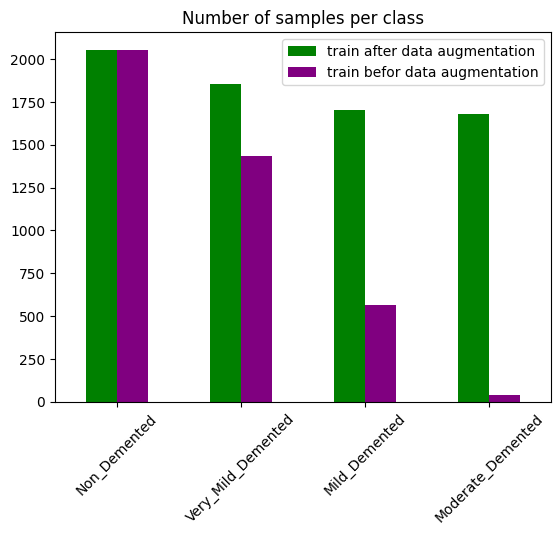

In [19]:
##### plot class distribution before and after the augmentation #####
train_labels_names=['Mild_Demented' if el==0 else 'Moderate_Demented' if el==1 else 'Non_Demented'  if el==2 else 'Very_Mild_Demented'   for el in augmented_labels]
vis_ratio = False # if we want to plot the num of samples or the ratio of each class
vis_title = 'Percentage of samples per class' if vis_ratio else 'Number of samples per class'
df_cnt = pd.concat([pd.Series(train_labels_names).value_counts(normalize=vis_ratio), pd.Series(train_labels).value_counts(normalize=vis_ratio)], axis=1)
df_cnt.plot(kind='bar', title=vis_title, rot=45, color = ['green', 'purple']) # added color to avoid confusion with train/val color setting
plt.legend(['train after data augmentation', 'train before data augmentation'])
plt.savefig('Data augmentation results.png')

COMMENTS: data of class "Mild_Demented" and "Moderate_Demented" were augmented properly but their number of samples doesn't overcome the most numerous class (Non_Demented)

# Build the ML Model

We'll be using the same architecture for our model as my [Pneumonia Classification NB](https://www.kaggle.com/amyjang/tensorflow-pneumonia-classification-on-x-rays#4.-Build-the-CNN). Using `tf.keras`, we can easily build up the layers of our CNN.

NEW: we decided not to change model internal architecture (unless changing Dropout in later hyperparameters tuning) due to limited expertize and time

In [ ]:
def conv_block(filters):
    block = tf.keras.Sequential([
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPool2D()
    ]
    )

    return block

def dense_block(units, dropout_rate, L2): # add regularization at the dense layer (dense layer has are more or less fulliconnected, is important to reguraraze weight in order to avoid overfitting)
    block = tf.keras.Sequential([
        tf.keras.layers.Dense(units, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(L2)),
        tf.keras.layers.BatchNormalization(), #change the layer: is not practice use a batch normalization after a relu activation
        tf.keras.layers.Dropout(dropout_rate)
    ])

    return block

def build_model_original():
    model = tf.keras.Sequential([
        tf.keras.Input(shape=(*IMAGE_SIZE, 3)),

        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.MaxPool2D(),

        conv_block(32),
        conv_block(64),

        conv_block(128),
        tf.keras.layers.Dropout(0.2),

        conv_block(256),
        tf.keras.layers.Dropout(0.2),

        tf.keras.layers.Flatten(),
        dense_block(512, 0.7, 0),
        dense_block(128, 0.5, 0),
        dense_block(64, 0.2, 0),

        tf.keras.layers.Dense(NUM_CLASSES, activation='softmax')
    ])

    return model

def build_model_tunable(L2,drop_out):
    model = tf.keras.Sequential([
        tf.keras.Input(shape=(*IMAGE_SIZE, 3)),

        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.MaxPool2D(),

        conv_block(32),
        conv_block(64),

        conv_block(128),
        tf.keras.layers.Dropout(drop_out),

        conv_block(256),
        tf.keras.layers.Dropout(drop_out),

        tf.keras.layers.Flatten(),
        dense_block(512, drop_out*3, L2),
        dense_block(128, drop_out*2, L2),
        dense_block(64, drop_out, L2),

        tf.keras.layers.Dense(NUM_CLASSES, activation='softmax')
    ])

    return model

In [ ]:
#tf.keras.utils.plot_model(model, to_file="cnn.png", show_shapes=True) #plot the network

# Training the Model

To more efficiently train our model. We will be using callbacks to adjust our learning rate and to stop our model once it converges.

The [learning rate](https://developers.google.com/machine-learning/glossary#learning-rate) is a very important hyperparameter in the model. Having a LR that is too high will prevent the model from converging. Having a LR that is too slow will make the process too long. Stopping our model early is one mechanism that prevents overfitting.

NEW;  we  plot different time decays for learning rate, assuming for example 50 epochs, to see how it decreases with epochs. We try then fitting the model with some of these learning decays and some of their parameters.

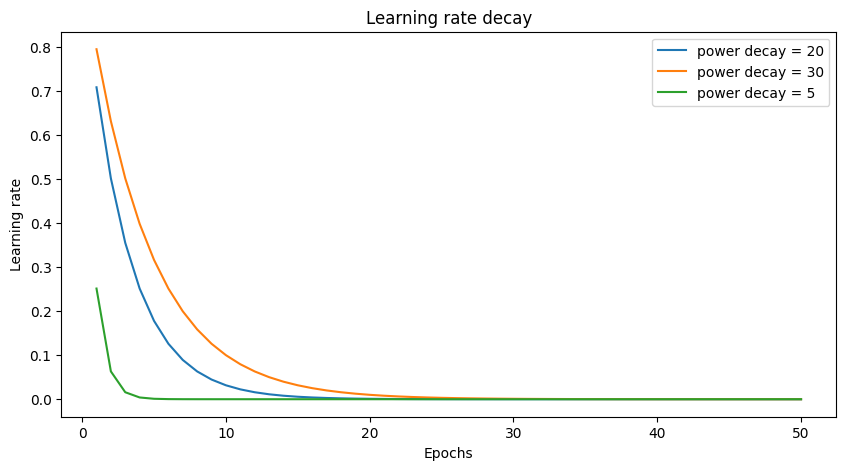

In [ ]:
### plot different learning decays rates ####
def exponential_decay(s):
    def exponential_decay_fn(epoch):
        return 0.001 **(epoch / s)
    return exponential_decay_fn

epochs=np.linspace(1,50,50)
lr_epochs=0.001**(epochs / 20)
lr_epochs2=0.001**(epochs/30)
lr_epochs3=0.001**(epochs / 5)

plt.figure(figsize=(10,5))
plt.plot(epochs, lr_epochs,label="power decay = 20")
plt.plot(epochs, lr_epochs2,label="power decay = 30")
plt.plot(epochs, lr_epochs3,label="power decay = 5")

plt.title("Learning rate decay")
plt.xlabel("Epochs")
plt.ylabel("Learning rate")
plt.legend()

plt.savefig('Learning_Rate_Decay.png')

Let's fit our model!

# NEW: MORE MODELS
SEBASTIANO HAS TO WRITE HERE

In [ ]:
# ORIGINAL MODEL WITH ORIGINAL DATA
model_name = 'Original_model.h5'
EPOCHS = 100

with strategy.scope():
    model = build_model_original()
    plot_model(model, show_shapes=True)
    
    METRICS = [tf.keras.metrics.AUC(name='auc')]

    model.compile(
        optimizer='adam',
        loss=tf.losses.CategoricalCrossentropy(),
        metrics=METRICS
    )

exponential_decay_fn = exponential_decay(20)

lr_scheduler = tf.keras.callbacks.LearningRateScheduler(exponential_decay_fn)
checkpoint_cb = tf.keras.callbacks.ModelCheckpoint(model_name,save_best_only=True)
early_stopping_cb = tf.keras.callbacks.EarlyStopping(monitor="loss", patience=5, restore_best_weights=True)

history_original = model.fit(        #for each epochs the data are shuffled and a portion is used as valid test
    train_ds,
    batch_size = BATCH_SIZE,
    validation_data=val_ds,
    callbacks=[checkpoint_cb, early_stopping_cb, lr_scheduler],
    verbose = 1, #progression bar
    epochs=EPOCHS
)

Epoch 1/100
256/256 [==============================] - ETA: 0s - loss: 19.4999 - auc: 0.6184

C:\Users\Utente\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\engine\training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


256/256 [==============================] - 79s 287ms/step - loss: 19.4999 - auc: 0.6184 - val_loss: 2926531928129536.0000 - val_auc: 0.4682 - lr: 1.0000
Epoch 2/100
256/256 [==============================] - 74s 290ms/step - loss: 4.9106 - auc: 0.6729 - val_loss: 2.0376 - val_auc: 0.7217 - lr: 0.7079
Epoch 3/100
256/256 [==============================] - 72s 281ms/step - loss: 1.5422 - auc: 0.7428 - val_loss: 1.3765 - val_auc: 0.7445 - lr: 0.5012
Epoch 4/100
256/256 [==============================] - 72s 283ms/step - loss: 1.2469 - auc: 0.7508 - val_loss: 1.1468 - val_auc: 0.7937 - lr: 0.3548
Epoch 5/100
256/256 [==============================] - 73s 285ms/step - loss: 1.1095 - auc: 0.7693 - val_loss: 1.0635 - val_auc: 0.7917 - lr: 0.2512
Epoch 6/100
256/256 [==============================] - 72s 281ms/step - loss: 1.0631 - auc: 0.7788 - val_loss: 1.0613 - val_auc: 0.8085 - lr: 0.1778
Epoch 7/100
256/256 [==============================] - 70s 275ms/step - loss: 1.0468 - auc: 0.7826 - v

In [ ]:
# ORIGINAL MODEL WITH AUGMENTED DATA
model_name = 'Original_model_augmented_data.h5'
EPOCHS = 100

with strategy.scope():
    model = build_model_original()
    
    plot_model(model, show_shapes=True)
    
    METRICS = [tf.keras.metrics.AUC(name='auc')]

    model.compile(
        optimizer='adam',
        loss=tf.losses.CategoricalCrossentropy(),
        metrics=METRICS
    )

exponential_decay_fn = exponential_decay(20)

lr_scheduler = tf.keras.callbacks.LearningRateScheduler(exponential_decay_fn)
checkpoint_cb = tf.keras.callbacks.ModelCheckpoint(model_name,save_best_only=True)
early_stopping_cb = tf.keras.callbacks.EarlyStopping(monitor="loss", patience=5, restore_best_weights=True)

history_original_AUG = model.fit(        #for each epochs the data are shuffled and a portion is used as valid test
    train_ds_aug,
    batch_size = BATCH_SIZE,
    validation_data=val_ds,
    callbacks=[checkpoint_cb, early_stopping_cb, lr_scheduler],
    verbose = 1, #progression bar
    epochs=EPOCHS
)

Epoch 1/100
72/72 [==============================] - ETA: 0s - loss: 13.1584 - auc: 0.5185

C:\Users\Utente\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\engine\training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


72/72 [==============================] - 137s 2s/step - loss: 13.1584 - auc: 0.5185 - val_loss: 1995.0793 - val_auc: 0.3598 - lr: 1.0000
Epoch 2/100
72/72 [==============================] - 137s 2s/step - loss: 2.2706 - auc: 0.5891 - val_loss: 17.3946 - val_auc: 0.6631 - lr: 0.7079
Epoch 3/100
72/72 [==============================] - 127s 2s/step - loss: 1.3881 - auc: 0.6336 - val_loss: 1.3189 - val_auc: 0.7561 - lr: 0.5012
Epoch 4/100
72/72 [==============================] - 140s 2s/step - loss: 1.3555 - auc: 0.6456 - val_loss: 2.2760 - val_auc: 0.2884 - lr: 0.3548
Epoch 5/100
72/72 [==============================] - 127s 2s/step - loss: 1.3243 - auc: 0.6427 - val_loss: 2.4978 - val_auc: 0.7776 - lr: 0.2512
Epoch 6/100
72/72 [==============================] - 131s 2s/step - loss: 1.2781 - auc: 0.6652 - val_loss: 1.1176 - val_auc: 0.7637 - lr: 0.1778
Epoch 7/100
72/72 [==============================] - 135s 2s/step - loss: 1.2537 - auc: 0.6790 - val_loss: 1.5282 - val_auc: 0.4797 - lr:

In [ ]:
#Hyperparameter tuning with augmented data
'''
drop_out = [0.1, 0.2, 0.3]
s = [5, 20, 30]
L2 = [1e-4, 1e-3, 1e-2]
'''
drop_out = [0.1]
s = [20]
L2 = [1e-3]

EPOCHS = 40

hparam = {
    'drop_out' : drop_out,
    's' : s,
    'L2' : L2
}

hparam_grid = ParameterGrid(hparam)

history = dict()

for p in hparam_grid:
    drop_out = p['drop_out']
    s = p['s']
    L2 = p['L2']

    model_name = 's_'+str(s)+'_L2_'+str(L2)+'_dropOut_'+str(drop_out)+'.h5'

    with strategy.scope():
        model = build_model_tunable(L2,drop_out)

        METRICS = [tf.keras.metrics.AUC(name='auc')]

        model.compile(
            optimizer='adam',
            loss=tf.losses.CategoricalCrossentropy(),
            metrics=METRICS
        )

    exponential_decay_fn = exponential_decay(s)

    lr_scheduler = tf.keras.callbacks.LearningRateScheduler(exponential_decay_fn)
    checkpoint_cb = tf.keras.callbacks.ModelCheckpoint(model_name,save_best_only=True)
    early_stopping_cb = tf.keras.callbacks.EarlyStopping(monitor="loss", patience=5, restore_best_weights=True)

    history[model_name] = model.fit(        #for each epochs the data are shuffled and a portion is used as valid test
        train_ds_aug,
        batch_size = BATCH_SIZE,
        validation_data=val_ds,
        callbacks=[checkpoint_cb, early_stopping_cb, lr_scheduler],
        verbose = 1, #progression bar
        epochs=EPOCHS
    )


Epoch 1/40


72/72 [==============================] - 119s 2s/step - loss: 932.1738 - auc: 0.5509 - val_loss: 44215.7539 - val_auc: 0.3399 - lr: 1.0000
Epoch 2/40
72/72 [==============================] - 104s 1s/step - loss: 933.6704 - auc: 0.5557 - val_loss: 4587.6299 - val_auc: 0.5666 - lr: 0.7079
Epoch 3/40
72/72 [==============================] - 102s 1s/step - loss: 387.6885 - auc: 0.5089 - val_loss: 150.6632 - val_auc: 0.4079 - lr: 0.5012
Epoch 4/40
72/72 [==============================] - 102s 1s/step - loss: 119.6970 - auc: 0.5477 - val_loss: 98.4021 - val_auc: 0.3955 - lr: 0.3548
Epoch 5/40
72/72 [==============================] - 104s 1s/step - loss: 94.1250 - auc: 0.5775 - val_loss: 75.5811 - val_auc: 0.7444 - lr: 0.2512
Epoch 6/40
72/72 [==============================] - 102s 1s/step - loss: 63.3415 - auc: 0.6012 - val_loss: 57.0294 - val_auc: 0.3085 - lr: 0.1778
Epoch 7/40
72/72 [==============================] - 102s 1s/step - loss: 53.0452 - auc: 0.6089 - val_loss: 49.1107 - val_auc:

# Visualize Model Metrics

Let's graph the ROC AUC metric and loss after each epoch for the training and validation data. Although we didn't use a random seed for our notebook, the results may slightly vary, generally the scores for the validataion data is similar, if not better, than the training dataset.

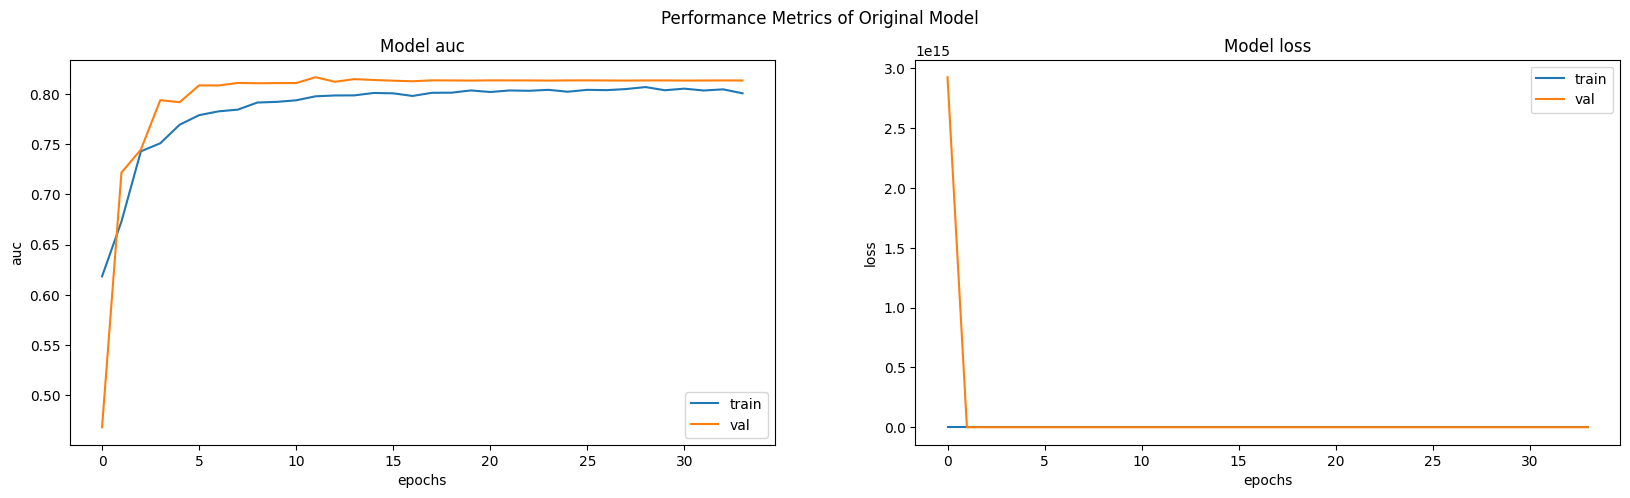

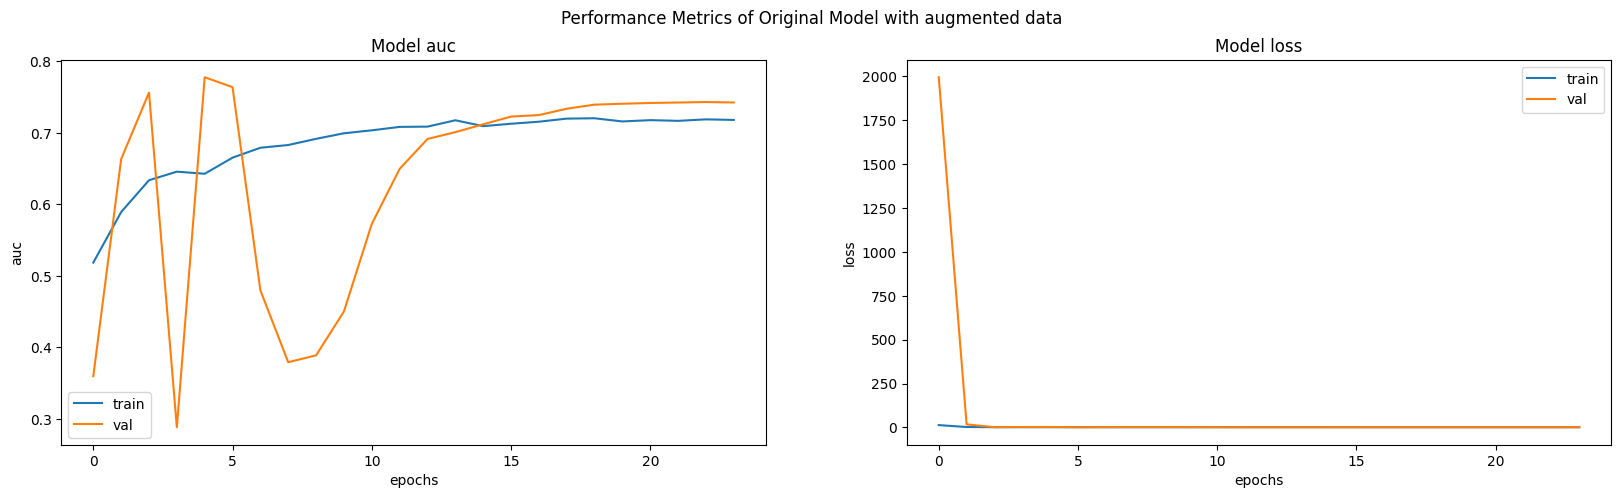

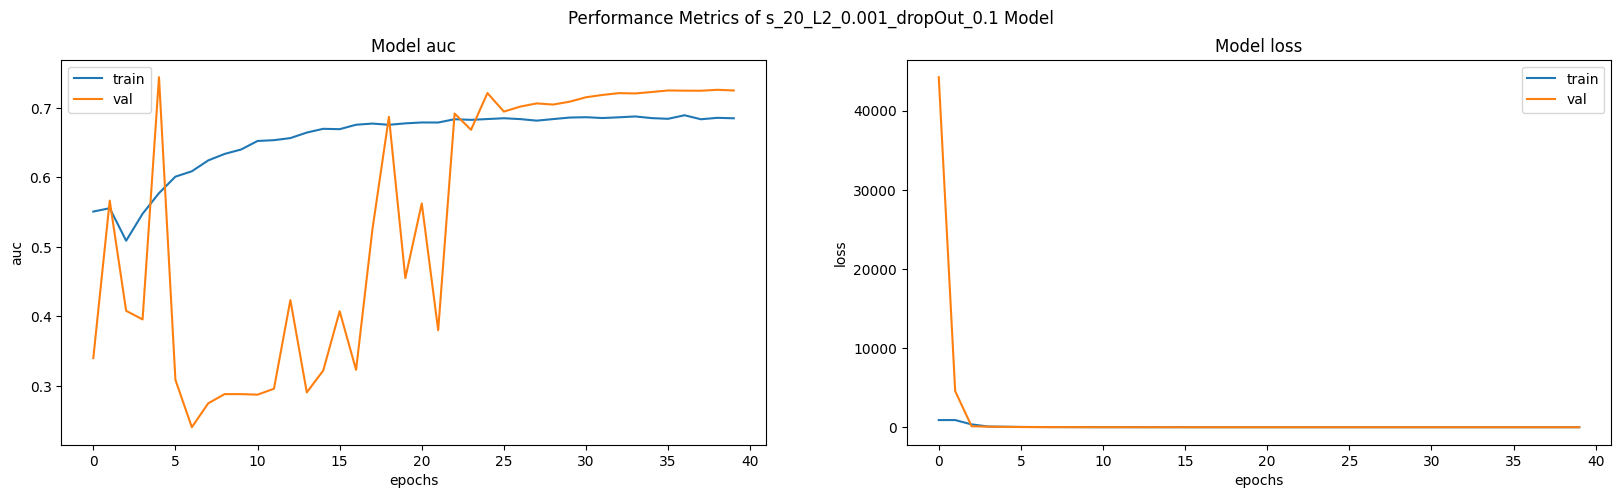

In [ ]:
# Original model
fig, ax = plt.subplots(1, 2, figsize=(20, 5))
ax = ax.ravel()

for i, met in enumerate(['auc', 'loss']):
    ax[i].plot(history_original.history[met])
    ax[i].plot(history_original.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

plt.suptitle('Performance Metrics of Original Model')
plt.savefig('Original_model.png')


# Original model AUGMENTED DATA
fig, ax = plt.subplots(1, 2, figsize=(20, 5))
ax = ax.ravel()

for i, met in enumerate(['auc', 'loss']):
    ax[i].plot(history_original_AUG.history[met])
    ax[i].plot(history_original_AUG.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

plt.suptitle('Performance Metrics of Original Model with augmented data')
plt.savefig('Original_model_AUG.png')


#tunable models with augmanted dataset
for k in history.keys():
    fig, ax = plt.subplots(1, 2, figsize=(20, 5))
    ax = ax.ravel()
    for i, met in enumerate(['auc', 'loss']):
        ax[i].plot(history[k].history[met])
        ax[i].plot(history[k].history['val_' + met])
        ax[i].set_title('Model {}'.format(met))
        ax[i].set_xlabel('epochs')
        ax[i].set_ylabel(met)
        ax[i].legend(['train', 'val'])

    plt.suptitle('Performance Metrics of '+k[:-3]+' Model')

    plt.savefig(k[:-3]+'.png')





#### Look at other metrics ####

# Cohen's Kappa
kappa_metric = tf.metrics.CohenKappa(num_classes=NUM_CLASSES,name='cohen_kappa')

# SpecificityAtSensitivity (specificity at a given sensitivity), computes best specificity where sensitivity is >= specified value.
specificity_at_sensitivity = tf.keras.metrics.SpecificityAtSensitivity(sensitivity=0.8, num_thresholds=200, class_id=None, name='specificity_at_sensitivity', dtype=None)

# Recall (calculates the recall (sensitivity) of a model)
recall = tf.keras.metrics.Recall(thresholds=None, top_k=None, class_id=None, name='recall', dtype=None)

ax = ax.ravel()

# add acc,f1,cohen,recall,sensitivity at specificity and plot them during epochs
for i, met in enumerate(['accuracy', 'f1','cohen_kappa','recall']):  #['auc', 'loss', 'accuracy', 'f1','cohen_kappa','recall','specificity_at_sensitivity']
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

# Evaluate the Model

Although we used the validatation dataset to continually evaluate the model, we also have a separate testing dataset. Let's prepare the testing dataset.

In [ ]:
test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "Dataset/test",
    image_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
)

test_ds = test_ds.map(one_hot_label, num_parallel_calls=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

Found 1281 files belonging to 4 classes.


# NEW: PLOT CONFUSION MATRIX & PRINT METRICS
 
 NEW: the original code simply evaluated auc and loss on test set. We also define a function to plot confusion matrix, display test loss and test accuracy , report also other classification metrics for all the models implemented ( recall, f1-score, specifity at sensitivity, Cohen's kappa )

In [ ]:
def plot_confusion_matrix(cm, classes, normalize= False, title= 'Confusion Matrix', cmap= plt.cm.Blues):
	#This function plot confusion matrix method from sklearn package.


	plt.figure(figsize= (12, 12))
	plt.imshow(cm, interpolation= 'nearest', cmap= cmap)
	plt.title(title)
	plt.colorbar()

	tick_marks = np.arange(len(classes))
	plt.xticks(tick_marks, classes, rotation= 45)
	plt.yticks(tick_marks, classes)

	if normalize:
		cm = cm.astype('float') / cm.sum(axis= 1)[:, np.newaxis]
		print('Normalized Confusion Matrix')

	else:
		print('Confusion Matrix, Without Normalization')

	print(cm)

	thresh = cm.max() / 2.
	for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
		plt.text(j, i, cm[i, j], horizontalalignment= 'center', color= 'white' if cm[i, j] > thresh else 'black')

	plt.tight_layout()
	plt.ylabel('True Label')
	plt.xlabel('Predicted Label')

	plt.savefig(title+'.png')


13/13 [==============================] - 4s 309ms/step
Test Loss:  0.9899918437004089
Test Accuracy:  0.8070577383041382
Confusion Matrix, Without Normalization
[[  0   0 118  62]
 [  0   0  11   2]
 [  0   0 538 102]
 [  0   0 341 107]]


C:\Users\Utente\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Utente\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Utente\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1

                    precision    recall  f1-score   support

     Mild_Demented       0.00      0.00      0.00       180
 Moderate_Demented       0.00      0.00      0.00        13
      Non_Demented       0.53      0.84      0.65       640
Very_Mild_Demented       0.39      0.24      0.30       448

          accuracy                           0.50      1281
         macro avg       0.23      0.27      0.24      1281
      weighted avg       0.40      0.50      0.43      1281

13/13 [==============================] - 5s 346ms/step
Test Loss:  1.1302696466445923
Test Accuracy:  0.7610586881637573
Confusion Matrix, Without Normalization
[[  0  68 112   0]
 [  0   4   9   0]
 [  0  86 554   0]
 [  0 102 346   0]]
                    precision    recall  f1-score   support

     Mild_Demented       0.00      0.00      0.00       180
 Moderate_Demented       0.02      0.31      0.03        13
      Non_Demented       0.54      0.87      0.67       640
Very_Mild_Demented       0.00      0.0

C:\Users\Utente\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Utente\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Utente\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1

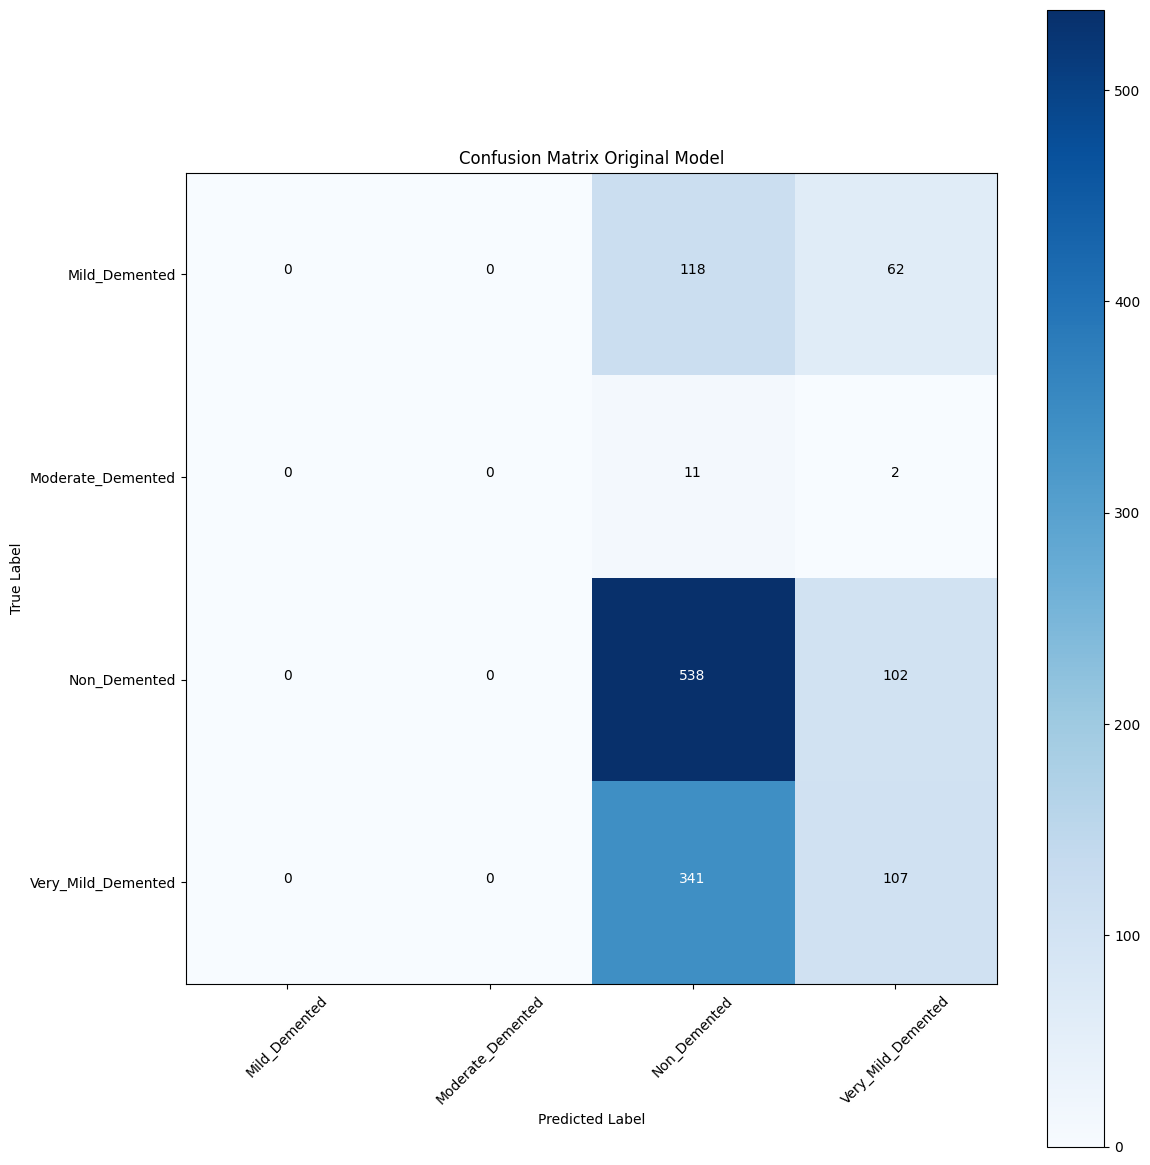

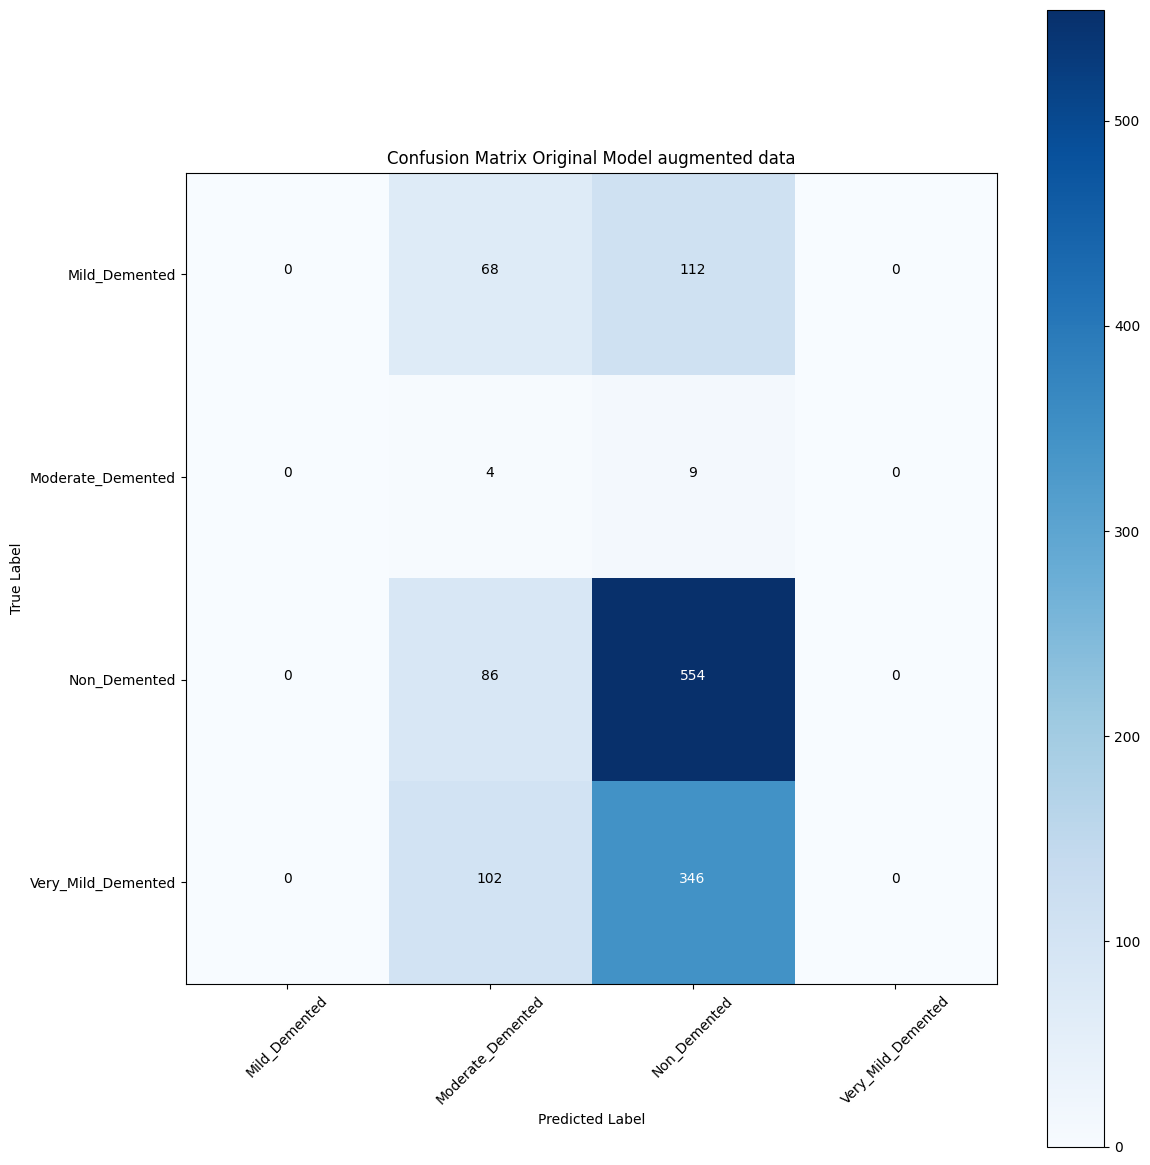

In [ ]:

y_true=labels_fromPrefetch(test_ds)

# Original model 
model = load_model('Original_model.h5')
test_score = model.evaluate(test_ds)
test_pred = model.predict(test_ds)
y_pred = np.argmax(test_pred, axis=1) #prediction to class labels

train_score = model.evaluate(train_ds, verbose= 1)
valid_score = model.evaluate(val_ds, verbose= 1)

print("Test Loss: ", test_score[0])
print("Test Accuracy: ", test_score[1])
print('-' * 20)
print("Validation Loss: ", valid_score[0])
print("Validation Accuracy: ", valid_score[1])
print('-' * 20)
print("Test Loss: ", test_score[0])
print("Test Accuracy: ", test_score[1])

cm= confusion_matrix(y_true, y_pred)
plot_confusion_matrix(cm= cm, classes= classes, title = 'Confusion Matrix Original Model')
print(classification_report(y_true, y_pred, target_names= classes))



# Original model with augmented data
model = load_model('Original_model_augmented_data.h5')
test_score = model.evaluate(test_ds)
test_pred = model.predict(test_ds)
y_pred = np.argmax(test_pred, axis=1) #prediction to class labels

train_score = model.evaluate(train_ds, verbose= 1)
valid_score = model.evaluate(val_ds, verbose= 1)


print("Test Loss: ", test_score[0])
print("Test Accuracy: ", test_score[1])
print('-' * 20)
print("Validation Loss: ", valid_score[0])
print("Validation Accuracy: ", valid_score[1])
print('-' * 20)
print("Test Loss: ", test_score[0])
print("Test Accuracy: ", test_score[1])

print("Test Loss: ", test_score[0])
print("Test Accuracy: ", test_score[1])
cm= confusion_matrix(y_true, y_pred)
plot_confusion_matrix(cm= cm, classes= classes, title = 'Confusion Matrix Original Model augmented data')
print(classification_report(y_true, y_pred, target_names= classes))


#  Models with hyperparameters tuning: TO DO


13/13 [==============================] - 5s 328ms/step
Test Loss:  29.860427856445312
Test AUC:  0.7118409276008606
Confusion Matrix, Without Normalization
[[ 79  10  25  66]
 [  3   2   5   3]
 [115  31 385 109]
 [119  27 162 140]]
                    precision    recall  f1-score   support

     Mild_Demented       0.25      0.44      0.32       180
 Moderate_Demented       0.03      0.15      0.05        13
      Non_Demented       0.67      0.60      0.63       640
Very_Mild_Demented       0.44      0.31      0.37       448

          accuracy                           0.47      1281
         macro avg       0.35      0.38      0.34      1281
      weighted avg       0.52      0.47      0.49      1281



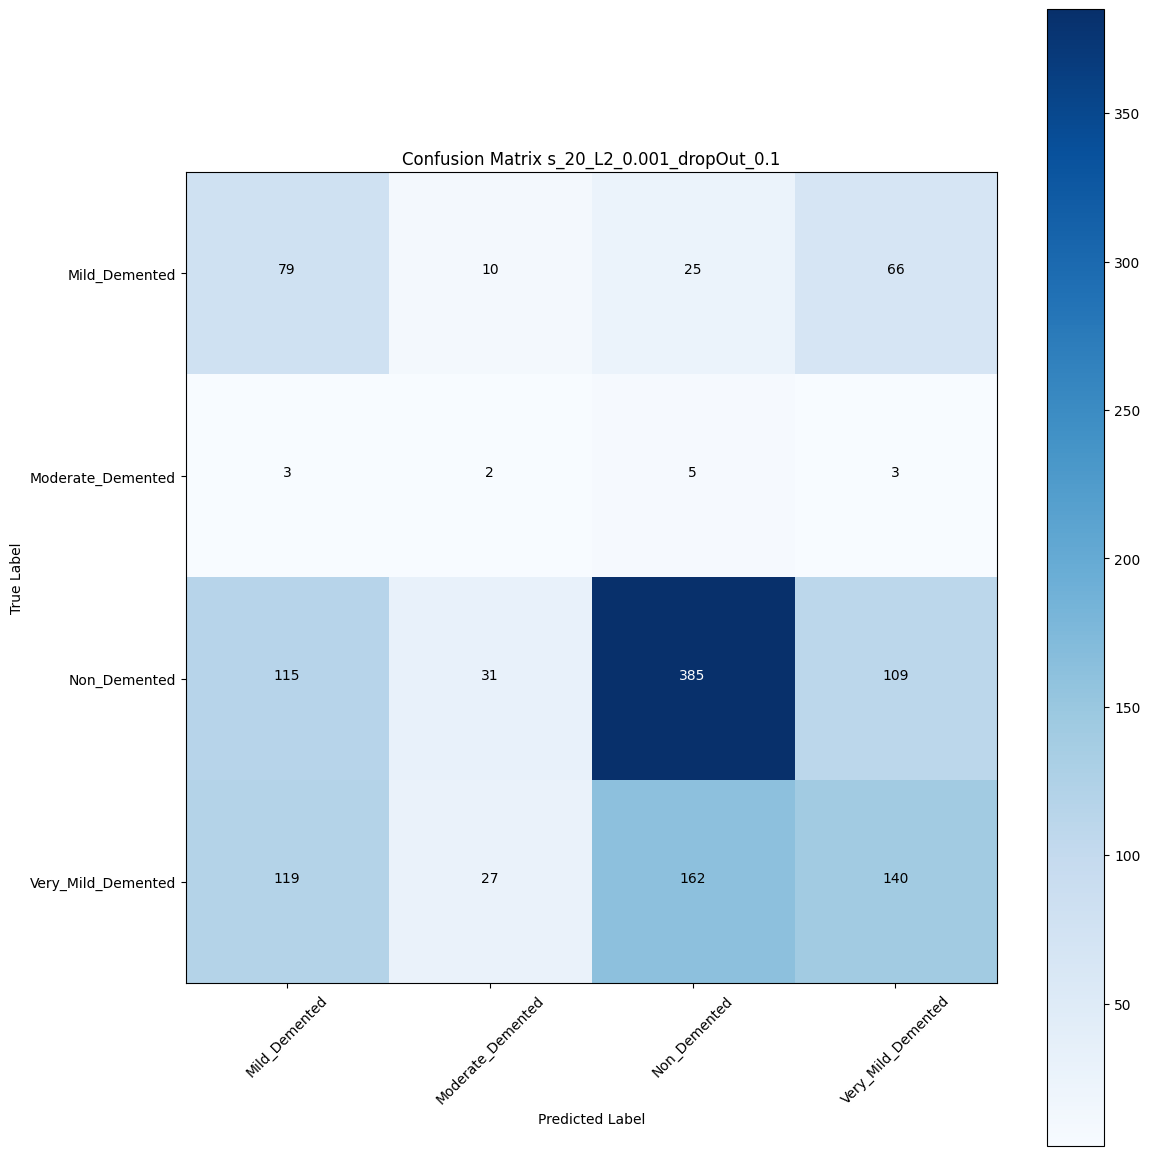

In [ ]:
for k in history.keys():
    model = load_model(k)
    test_score = model.evaluate(test_ds)
    test_pred = model.predict(test_ds)
    y_pred = np.argmax(test_pred, axis=1) #prediction to class labels
    print("Test Loss: ", test_score[0])
    print("Test AUC: ", test_score[1])

    cm= confusion_matrix(y_true, y_pred)
    plot_confusion_matrix(cm= cm, classes= classes, title = 'Confusion Matrix '+k[:-3])
    print(classification_report(y_true, y_pred, target_names= classes))


# NEW: display balanced accuracy

We also display balanced accuracy on test set, training set, and validation set. Despite leveling classes, our data augmentation still produces a slighlty unbalanced training set: this is why we also check balanced accuracy

In [ ]:
### display balanced accuracy ###

# Original model

train_labels=labels_fromPrefetch(train_ds)

start_pred_orig=time.time()
train_predictions = model.predict(train_ds)
train_pred_labels = np.argmax(train_predictions, axis=1) # Convert predictions to class labels
stop_pred_orig=time.time()

duration_pred_orig=stop_pred_orig-start_pred_orig

balanced_acc_train = balanced_accuracy_score(train_labels, train_pred_labels)

print("Balanced Accuracy Training Set:", balanced_acc_train)


val_labels=labels_fromPrefetch(val_ds)
val_predictions = model.predict(val_ds)
val_pred_labels = np.argmax(val_predictions, axis=1) # Convert predictions to class labels
balanced_acc_val = balanced_accuracy_score(val_labels, val_pred_labels)

print("Balanced Accuracy Validation Set:", balanced_acc_val)


test_labels=labels_fromPrefetch(val_ds)
preds = model.predict(test_ds)
y_pred = np.argmax(preds, axis=1) # Convert predictions to class labels
balanced_acc = balanced_accuracy_score(test_labels, y_pred)

print(y_pred)
print("Balanced Accuracy Test Set:", balanced_acc)



#O OTHER MODELS: TO DO !!

# LIMITATIONS ?
# POSSIBLE IMPROVEMENTS ?


# REFERENCES
[1]Nawaz, H., Maqsood, M., Afzal, S. et al. A deep feature-based real-time system for Alzheimer disease stage detection. Multimed Tools Appl 80, 35789–35807 (2021). https://doi.org/10.1007/s11042-020-09087-y


[2]Islam, J., Zhang, Y. Brain MRI analysis for Alzheimer’s disease diagnosis using an ensemble system of deep convolutional neural networks. Brain Inf. 5, 2 (2018). https://doi.org/10.1186/s40708-018-0080-3


[3]Kundaram, Swathi S. and Ketki C. Pathak. “Deep Learning-Based Alzheimer Disease Detection.” Lecture Notes in Electrical Engineering (2020)


[4]C.H. Suh, W.H. Shim, S.J. Kim, J.H. Roh, J.-H. Lee, M.-J. Kim, S. Park, W. Jung, J. Sung, G.-H. Jahng, and for the Alzheimer’s Disease Neuroimaging Initiative. American Journal of Neuroradiology December 2020, 41 (12) 2227-2234


[5]Mehmood A, Maqsood M, Bashir M, Shuyuan Y. A Deep Siamese Convolution Neural Network for Multi-Class Classification of Alzheimer Disease. Brain Sci. 2020 Feb 5;10(2):84. doi: 10.3390/brainsci10020084


[6]Ghazal, Taher & Abbas, Sagheer & Munir, Sundus & Khan, Muhammad & Ahmad, Munir & Issa, Ghassan & Zahra, Binish & Hasan, Mohammad Kamrul. (2021). Alzheimer Disease Detection Empowered with Transfer Learning. Computers, Materials and Continua. 70. 5005-5019. 10.32604/cmc.2022.020866


[7]A. W. Salehi, P. Baglat, B. B. Sharma, G. Gupta and A. Upadhya, "A CNN Model: Earlier Diagnosis and Classification of Alzheimer Disease using MRI," 2020 International Conference on Smart Electronics and Communication (ICOSEC), Trichy, India, 2020, pp. 156-161, doi: 10.1109/ICOSEC49089.2020.9215402



[8]A. Farooq, S. Anwar, M. Awais and S. Rehman, "A deep CNN based multi-class classification of Alzheimer's disease using MRI," 2017 IEEE International Conference on Imaging Systems and Techniques (IST), Beijing, China, 2017, pp. 1-6, doi: 10.1109/IST.2017.8261460


[9] Singh, Narotam & D, Patteshwari & Soni, Neha & Kapoor, Amita. (2022). Automated detection of Alzheimer disease using MRI images and deep neural networks- A review. 10.48550/arXiv.2209.11282


[10] Nawaz, Ali & Anwar, Syed & Liaqat, Rehan & Iqbal, Javid & Majid, Muhammad. (2021). Deep Convolutional Neural Network based Classification of Alzheimer's Disease using MRI data. 
